In [1]:
import os
import re
import nibabel as nib
import numpy as np
import time
from copy import deepcopy
from utils import load_fixel_data, load_image, load_connectome, generate_data_dict
from utils import time_to_string, print_progress
from fixel import fixel_comparison
from fod import fod_comparison
from graph_metrics import strengths_und, charpath, efficiency_wei
from connectome import significant_edges_t, significant_edges_w, graph_tests
from connectome import disparity_matrix, ranking_metrics


gt = '64dir'
main_path = '/media/transcend/Data/Fudan/'
# Check utils.py to understand the expected folder structure
data_dict = generate_data_dict(main_path, gt)
    
fod_sub_mae = []
fod_sub_mse = []
fod_sub_psnr = []
    
afd_sub_errors = []
afdall_sub_errors = []
peak_sub_errors = []
peakall_sub_errors = []
angular_sub_errors = []

conn_list = []
triu_list = []

for i, (sub, sub_data) in enumerate(data_dict.items()):
    print(' '.join([' '] * 300), end='\r')
    print('Subject {:} [{:02d}/{:02d}]'.format(
        sub, i + 1, len(data_dict.keys())
    ), end='\r')    
    
    roi = load_image(sub_data['wm']).astype(bool)
    
    # FODs
    fod_paths = [m['fod'] for m in sub_data['methods'].values()]
    gt_fod = load_image(sub_data['gt']['fod'])
    m_fod = [load_image(m) for m in fod_paths]
    mse_list, mae_list, psnr_list = fod_comparison(
        gt_fod, m_fod, roi
    )
    fod_sub_psnr.append([np.mean(e) for e in psnr_list])
    fod_sub_mse.append([np.mean(e) for e in mse_list])
    fod_sub_mae.append([np.mean(e) for e in mae_list])
    
    # Fixels
    fixel_paths = [m['fixel'] for m in sub_data['methods'].values()]
    gt_fixel_path =  sub_data['gt']['fixel']
    gt_index, gt_afd, gt_peak, gt_dir = load_fixel_data(gt_fixel_path)
    m_fixels = [load_fixel_data(m) for m in fixel_paths]
    m_index, m_afd, m_peak, m_dir = zip(*m_fixels)  
    valid_gt = gt_index[roi]
    valid_m = [m[roi] for m in m_index]
    angular_errors, (afd_e, extra_afd_e, miss_afd_e), (peak_e, extra_peak_e, miss_peak_e), = fixel_comparison(
        valid_gt, gt_peak, gt_afd, gt_dir,
        valid_m, m_peak, m_afd, m_dir
    )
    afd_sub_errors.append([np.mean(np.concatenate(e)) for e in afd_e])
    afdall_sub_errors.append([
        np.mean(np.concatenate(e + e_e + m_e))
        for e, e_e, m_e in zip(afd_e, extra_afd_e, miss_afd_e)
    ])
    peak_sub_errors.append([np.mean(np.concatenate(e)) for e in peak_e])
    peakall_sub_errors.append([
        np.mean(np.concatenate(e + e_e + m_e))
        for e, e_e, m_e in zip(peak_e, extra_peak_e, miss_peak_e)
    ])
    angular_sub_errors.append(angular_errors)
    
    # Connectomes
    sub_conn_list = []
    sub_triu_list = []
    gt_conn, gt_triu = load_connectome(sub_data['gt']['connectome']) 
    sub_conn_list.append(gt_conn)
    sub_triu_list.append(gt_triu)
    for m in sub_data['methods'].values():
        m_conn, m_triu = load_connectome(m['connectome']) 
        sub_conn_list.append(m_conn)
        sub_triu_list.append(m_triu)
    conn_list.append(np.array(sub_conn_list))
    triu_list.append(np.array(sub_triu_list))
    
    
all_conn = np.stack(conn_list, 1)
all_triu = np.stack(triu_list, 1)

pval_t, fdr_t, fwe_t, nocor_t = significant_edges_t(all_triu[0, ...], all_triu[1:, ...])
pval_w, fdr_w, fwe_w, nocor_w = significant_edges_w(all_triu[0, ...], all_triu[1:, ...])

str_t, str_w, eff_t, eff_w, cpath_t, cpath_w = graph_tests(all_conn[0, ...], all_conn[1:, ...])

disp = disparity_matrix(all_conn[0, ...], all_conn[1:, ...])

inter_corr, intra_corr = ranking_metrics(all_triu[0, ...], all_triu[1:, ...])
inter_taus, inter_wtaus, inter_iwtaus, inter_pvalues = inter_corr
intra_taus, intra_wtaus, intra_iwtaus, intra_pvalues = intra_corr

/home/mariano/p37/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/mariano/p37/lib/python3.7/site-packages/scipy/stats/stats.py:6453: RuntimeWarning: invalid value encountered in subtract
  d = (a - b).astype(np.float64)
/home/mariano/p37/lib/python3.7/site-packages/scipy/stats/morestats.py:3130: RuntimeWarning: invalid value encountered in subtract
  d = x - y


In [85]:
# FODs metrics
methods = list(sub_data['methods'].keys())

mae_string = ' | '.join([
    '{:04.2e}          '.format(p) 
    for p in np.mean(fod_sub_mae, axis=0)
])
mse_string = ' | '.join([
    '{:04.2e}          '.format(p) 
    for p in np.mean(fod_sub_mse, axis=0)
])
psnr_string = ' | '.join([
    '{:05.2f} dB          '.format(p) 
    for p in np.mean(fod_sub_psnr, axis=0)
])


    
print(
    'Metric (FODs)           |', ' | '.join(
        ['{:18}'.format(t) for t in methods]
    )
)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Mean absolute error     |', mae_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Mean squared error      |', mse_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('PSNR (dB)               |', psnr_string)

Metric (FODs)           | 32dir              | 32dir_sr           | 64dir_sr          
------------------------|--------------------|--------------------|-------------------
Mean absolute error     | 7.50e-01           | 1.13e+00           | 1.22e+00          
------------------------|--------------------|--------------------|-------------------
Mean squared error      | 2.86e-02           | 5.77e-02           | 6.63e-02          
------------------------|--------------------|--------------------|-------------------
PSNR (dB)               | 72.47 dB           | 68.24 dB           | 67.62 dB          


In [80]:
# Fixels metrics

methods = list(sub_data['methods'].keys())

afd_string = ' | '.join([
    '{:04.2e}          '.format(p) 
    for p in np.mean(afd_sub_errors, axis=0)
])
afd_extra_string = ' | '.join([
    '{:04.2e}*         '.format(p) 
    for p in np.mean(afdall_sub_errors, axis=0)
])
peak_string = ' | '.join([
    '{:04.2e}          '.format(p) 
    for p in np.mean(peak_sub_errors, axis=0)
])
peak_extra_string = ' | '.join([
    '{:04.2e}*         '.format(p) 
    for p in np.mean(peakall_sub_errors, axis=0)
])
angular_string = ' | '.join([
    '{:04.2e}          '.format(p) 
    for p in np.mean(angular_sub_errors, axis=0)
])


    
print(
    'Metric (fixels)         |', ' | '.join(
        ['{:18}'.format(t) for t in methods]
    )
)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('AFD error               |', afd_string)
print('                        |', afd_extra_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Peak error              |', peak_string)
print('                        |', peak_extra_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Angular error           |', angular_string)

Metric (fixels)         | 32dir              | 32dir_sr           | 64dir_sr          
------------------------|--------------------|--------------------|-------------------
AFD error               | 6.38e-02           | 1.27e-01           | 1.36e-01          
                        | 4.81e-02*          | 9.72e-02*          | 9.63e-02*         
------------------------|--------------------|--------------------|-------------------
Peak error              | 6.11e-02           | 1.36e-01           | 1.63e-01          
                        | 4.93e-02*          | 1.13e-01*          | 1.19e-01*         
------------------------|--------------------|--------------------|-------------------
Angular error           | 3.53e-01           | 3.65e-01           | 3.53e-01          


Metric (connectomes)    | 32dir              | 32dir_sr           | 64dir_sr          
------------------------||--------------------|--------------------|-------------------
Edge diff [FDR t]       | 000.00%            | 003.79%            | 013.74%           
------------------------|--------------------|--------------------|-------------------
Edge diff [FWE t]       | 000.00%            | 000.11%            | 000.32%           
------------------------|--------------------|--------------------|-------------------
Edge diff [t-test]      | 003.96%            | 016.64%            | 031.27%           
------------------------|--------------------|--------------------|-------------------
------------------------|--------------------|--------------------|-------------------
Edge diff [FDR W]       | 000.00%              | 000.00%              | 025.44%             
------------------------|--------------------|--------------------|-------------------
Edge diff [FWE W]       | 000.00%   

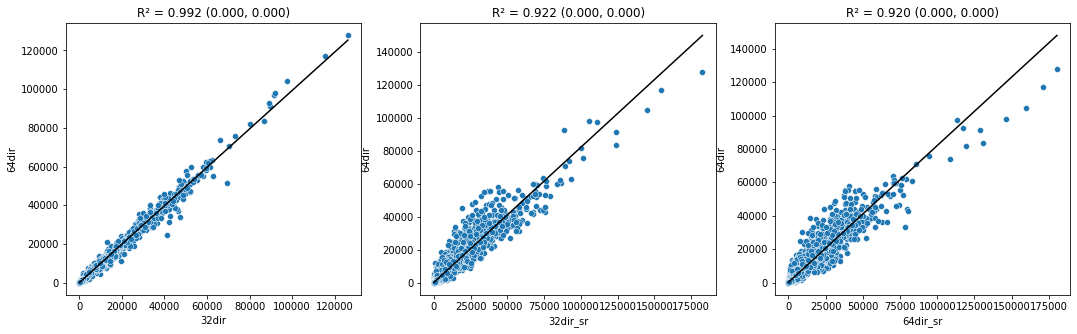

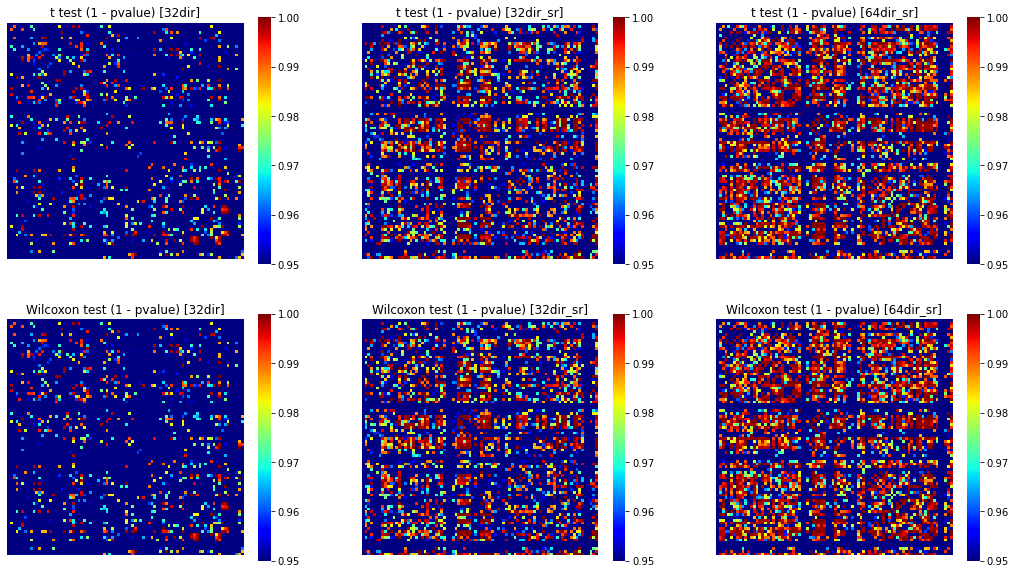

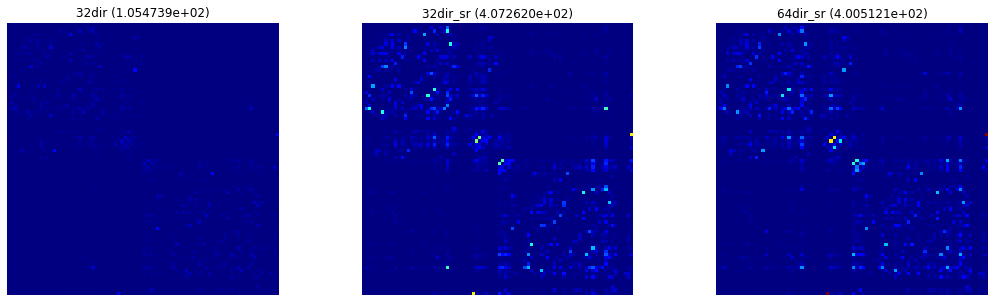

In [81]:
# Connectome plots and metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
from connectome import triu_to_graph
from utils import plot_correlation, plot_conn_masks

methods = list(sub_data['methods'].keys())

fdr_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in fdr_t
])

fwe_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in fwe_t
])

nocor_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in nocor_t
])
    
print(
    'Metric (connectomes)    |', ' | '.join(
        ['{:18}'.format(t) for t in methods]
    )
)
print('------------------------||-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FDR t]       |', fdr_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FWE t]       |', fwe_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [t-test]      |', nocor_string)

fdr_w_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in fdr_w
])

fwe_w_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in fwe_w
])

nocor_w_string = ' | '.join([
    '{:06.2f}%           '.format(p) 
    for p in nocor_w
])

print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FDR W]       |', fdr_w_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FWE W]       |', fwe_w_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [Wilcoxon]    |', nocor_w_string)

plt.figure(figsize=(len(methods) * 6, 5))
for i, m in enumerate(methods):
    plt.subplot(1, len(methods), i + 1)
    plot_correlation(all_triu[i + 1, ...].flatten(), all_triu[0, ...].flatten(), m, gt)
    
plt.figure(figsize=(len(methods) * 6, 10))
for i, m in enumerate(methods):
    plt.subplot(2, len(methods), i + 1)
    sn.heatmap(
        triu_to_graph(1 - pval_t[i]), xticklabels=False, yticklabels=False,
        square=True, cmap='jet', vmin=0.95, vmax=1
    )
    plt.title('t test (1 - pvalue) [{:}]'.format(m))
    plt.subplot(2, len(methods), len(methods) + i + 1)
    sn.heatmap(
        triu_to_graph(1 - pval_t[i]), xticklabels=False, yticklabels=False,
        square=True, cmap='jet', vmin=0.95, vmax=1
    )
    plt.title('Wilcoxon test (1 - pvalue) [{:}]'.format(m))

plt.figure(figsize=(len(methods) * 6, 5))   
for i, (d_conn, m) in enumerate(zip(disp, methods)):
    max_d = np.max(disp)
    plt.subplot(1, len(methods), i + 1)
    ax = sn.heatmap(d_conn, cmap='jet', cbar=False, vmin=0, vmax=max_d, square=True)
    ax.tick_params(right=False, top=False, left=False, bottom=False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('{:} ({:e})'.format(m, np.mean(d_conn[r, c])))
m = all_conn.shape[-1]
r, c = np.triu_indices(m, 1)
dconn_string = ' | '.join([
    '{:5.3e}         '.format(np.sum(d_conn[r, c])) for d_conn in disp
])
mdconn_string = ' | '.join([
    '{:5.3e}         '.format(np.mean(d_conn[r, c])) for d_conn in disp
])   
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Disparity (sum)         |', dconn_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('µDisparity              |', mdconn_string)

tau_string = ' | '.join([
    '{:4.2f} ± {:4.2f} ({:3.1f}) '.format(np.mean(tau), np.std(tau), pvalue)
    for tau, pvalue in zip(inter_taus, inter_pvalues)
] + [
    '{:4.2f} ± {:4.2f} ({:3.1f}) '.format(
        np.mean(intra_taus), np.std(intra_taus), np.mean(intra_pvalues)
    )
])
wtau_string = ' | '.join([
    '{:4.2f} ± {:4.2f} (-)   '.format(np.mean(tau), np.std(tau))
    for tau in inter_wtaus
] + [
    '{:4.2f} ± {:4.2f} (-) '.format(
        np.mean(intra_wtaus), np.std(intra_wtaus)
    )
])
iwtau_string = ' | '.join([
    '{:4.2f} ± {:4.2f} (-)   '.format(np.mean(tau), np.std(tau))
    for tau in inter_iwtaus
] + [
    '{:4.2f} ± {:4.2f} (-) '.format(
        np.mean(intra_iwtaus), np.std(intra_iwtaus)
    )
])
print(
    '------------------------|-' + '-|-'.join(['-' * 18] * len(methods)) + '-| {:18}'.format('Intersubject')
)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Kendall τ               |', tau_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Kendall W               |', wtau_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Inverse Kendall W       |', iwtau_string)

In [86]:
# Summary
print(
    'Metric (FODs)           |', ' | '.join(
        ['{:18}'.format(t) for t in methods]
    )
)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Mean absolute error     |', mae_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Mean squared error      |', mse_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('PSNR (dB)               |', psnr_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print(
    'Metric (fixels)         |-' + '-|-'.join(['-' * 18] * len(methods))
)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('AFD error               |', afd_string)
print('                        |', afd_extra_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Peak error              |', peak_string)
print('                        |', peak_extra_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Angular error           |', angular_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print(
    'Metric (connectomes)    |-' + '-|-'.join(['-' * 18] * len(methods))
)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FDR t]       |', fdr_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FWE t]       |', fwe_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [t-test]      |', nocor_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FDR W]       |', fdr_w_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [FWE W]       |', fwe_w_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Edge diff [Wilcoxon]    |', nocor_w_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('Disparity (sum)         |', dconn_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * len(methods)))
print('µDisparity              |', mdconn_string)
print(
    '------------------------|-' + '-|-'.join(['-' * 18] * len(methods)) + '-| {:18}'.format('Intersubject')
)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Kendall τ               |', tau_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Kendall W               |', wtau_string)
print('------------------------|-' + '-|-'.join(['-' * 18] * (len(methods) + 1)))
print('Inverse Kendall W       |', iwtau_string)

Metric (FODs)           | 32dir              | 32dir_sr           | 64dir_sr          
------------------------|--------------------|--------------------|-------------------
Mean absolute error     | 7.50e-01           | 1.13e+00           | 1.22e+00          
------------------------|--------------------|--------------------|-------------------
Mean squared error      | 2.86e-02           | 5.77e-02           | 6.63e-02          
------------------------|--------------------|--------------------|-------------------
PSNR (dB)               | 72.47 dB           | 68.24 dB           | 67.62 dB          
------------------------|--------------------|--------------------|-------------------
Metric (fixels)         |--------------------|--------------------|-------------------
------------------------|--------------------|--------------------|-------------------
AFD error               | 6.38e-02           | 1.27e-01           | 1.36e-01          
                        | 4.81e-02*        